# 0.0 Imports

In [18]:
import random 
import warnings

import datetime

import math
import numpy  as np
import pandas as pd
import inflection

import seaborn as sns

from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image

from scipy                 import stats 
from boruta                import BorutaPy

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import xgboost as xgb

import pickle 
import json

warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [2]:
# Função para configuração dos Plots
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
# X e Y são colunas do DataFrame de variáveis categóricas
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape 
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)     
    
    return np.sqrt((chi2corr/n)/min(kcorr-1, rcorr-1))

def mean_percentage_error(y, yhat): 
    return np.mean((y - yhat) / y)

# Performance Model
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name, 
                         'MAE': mae, 
                         'MAPE': mape, 
                         'RMSE': rmse}, index=[0])

# Cross_Validation
def cross_validation(x_training, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(kfold+1)):
        if verbose: 
            print(f'\n KFold Number: {k}')

        # start and end date for Validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k * 6 * 7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1) * 6 * 7)

        # Filtering Dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_start_date)]

        # Training and Validation Dataset
        # Training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # Validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        yhat = m.predict(xvalidation)

        # Performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        
        # Store Performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
    
    error_df = pd.DataFrame({'Model Name': model_name, 
                             'MAE CV': [str(round(np.mean(mae_list), 2)) + '+/-' + str(round(np.std(mae_list), 2))], 
                             'MAPE CV': [str(round(np.mean(mape_list), 2)) + '+/-' + str(round(np.std(mape_list), 2))], 
                             'RMSE CV': [str(round(np.mean(rmse_list), 2)) + '+/-' + str(round(np.std(rmse_list), 2))]})
    
    return error_df

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv( 'D:/Backup/Comunidade DS/Cursos/DS_Producao/data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'D:/Backup/Comunidade DS/Cursos/DS_Producao/data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0 Descrição dos Dados

In [5]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

In [7]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [8]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [9]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
566782,33,6,2014-02-08,8422,937,1,0,0,0,a,c,1320.0,5.0,2013.0,0,NaN,NaN,NaN


In [12]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

- Sempre que fizer uma transformação nas colunas do DF é legal ver os tipos dos dados

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [15]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

In [17]:
# Separando os valores númericos e descritivos

num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### Variaveis Numéricas

In [18]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
435027,963,6,4410,421,1,0,0,23620.0,11,2013,0,23,2014,0
518563,874,1,3486,465,1,0,0,3210.0,3,2014,0,13,2014,0


### Variaveis Categoricas

In [19]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
957750,0,a,a,0,Fev
121452,0,a,a,0,Apr


### 1.7.1 Numerical Attributes

In [20]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='sales', ylabel='Density'>

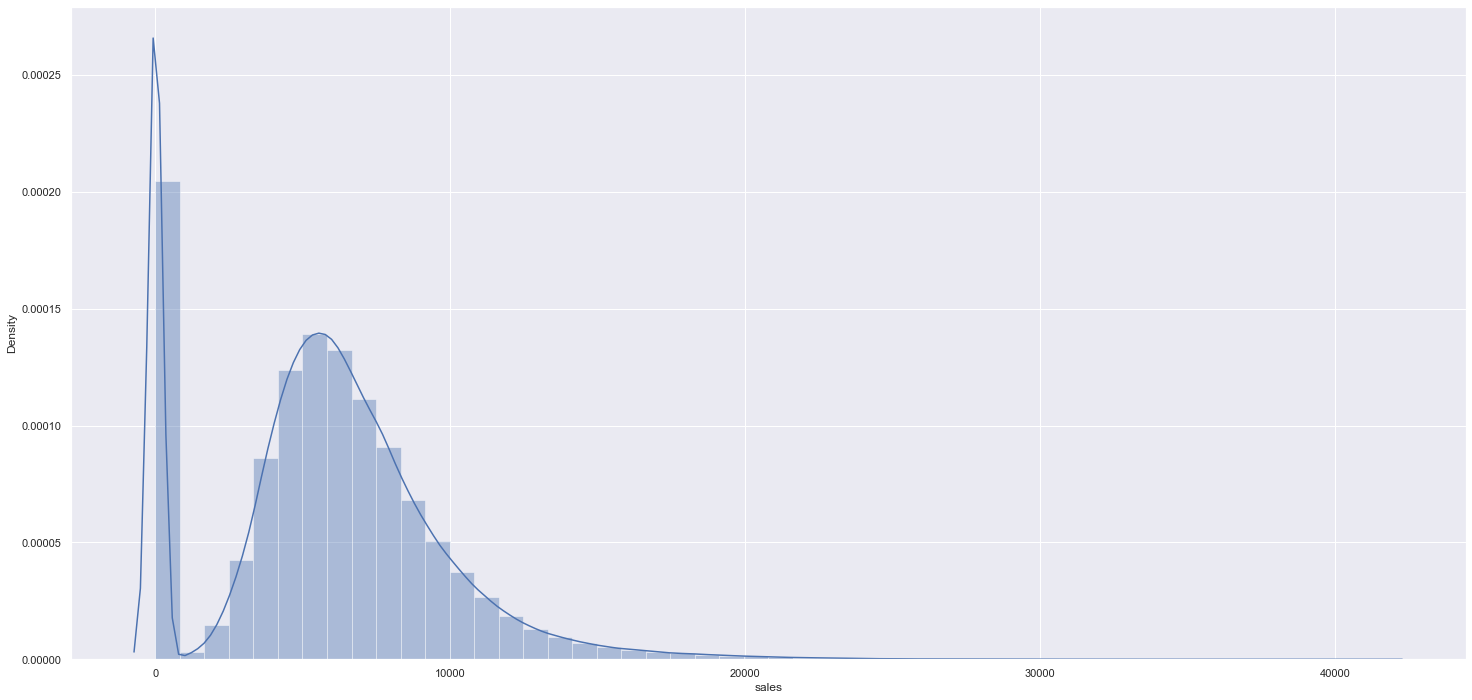

In [21]:
sns.distplot(df1['sales'])

<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

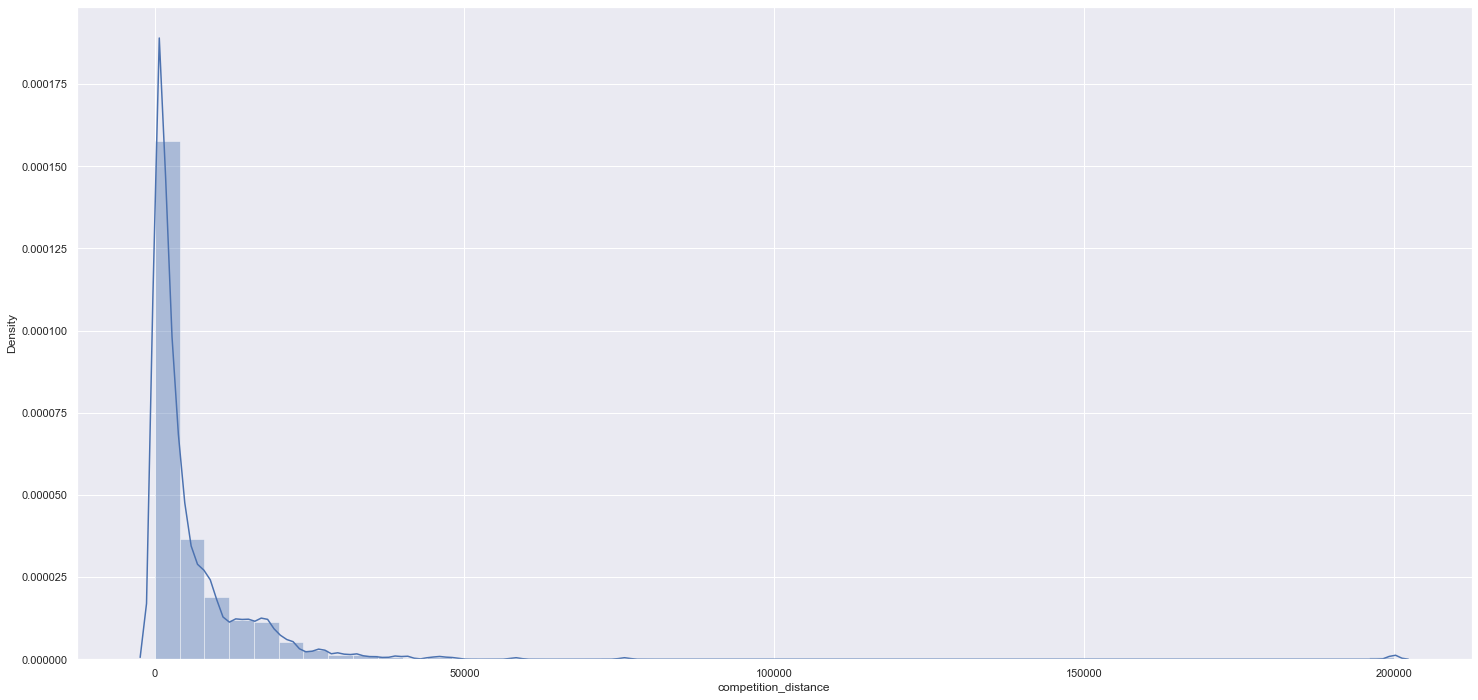

In [22]:
sns.distplot( df1['competition_distance'], kde=True )

### 1.7.2 Categorical Attributes

In [23]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

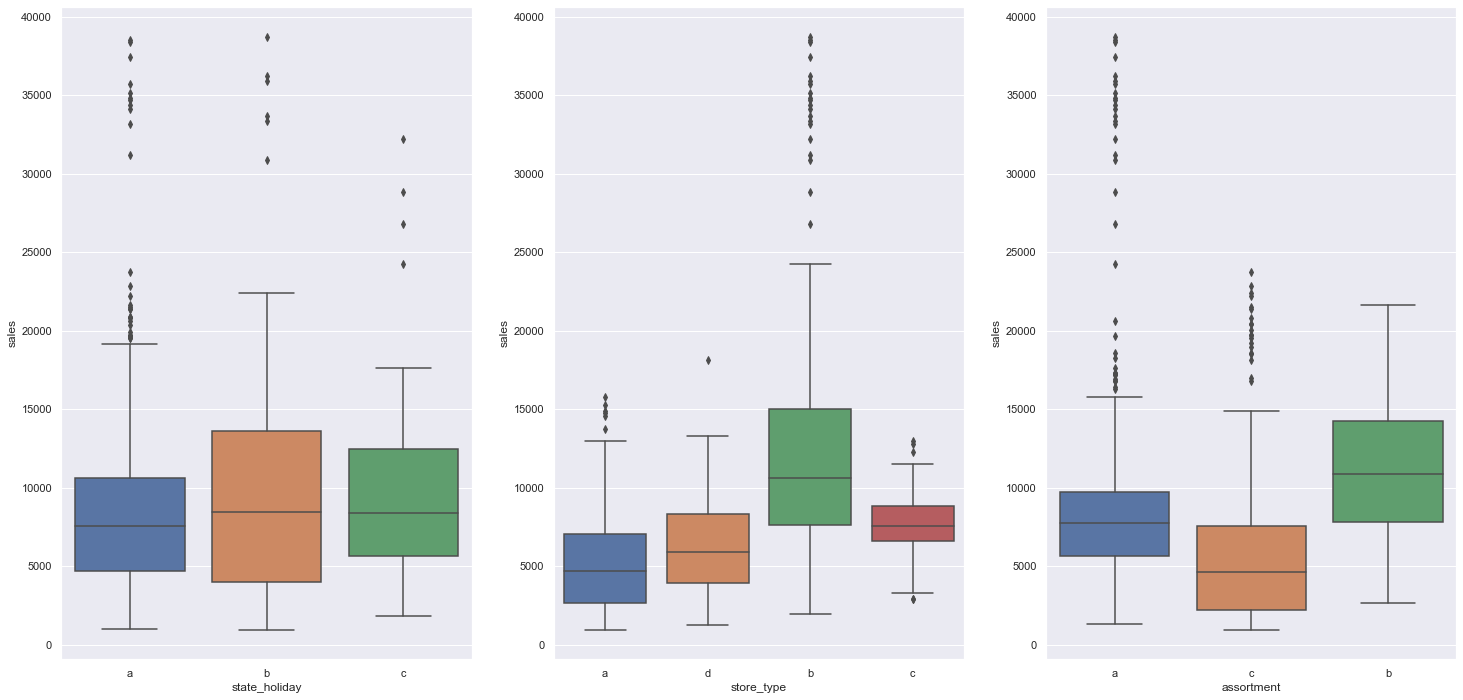

In [24]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0 Passo 02 - Feature Engineering

In [25]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

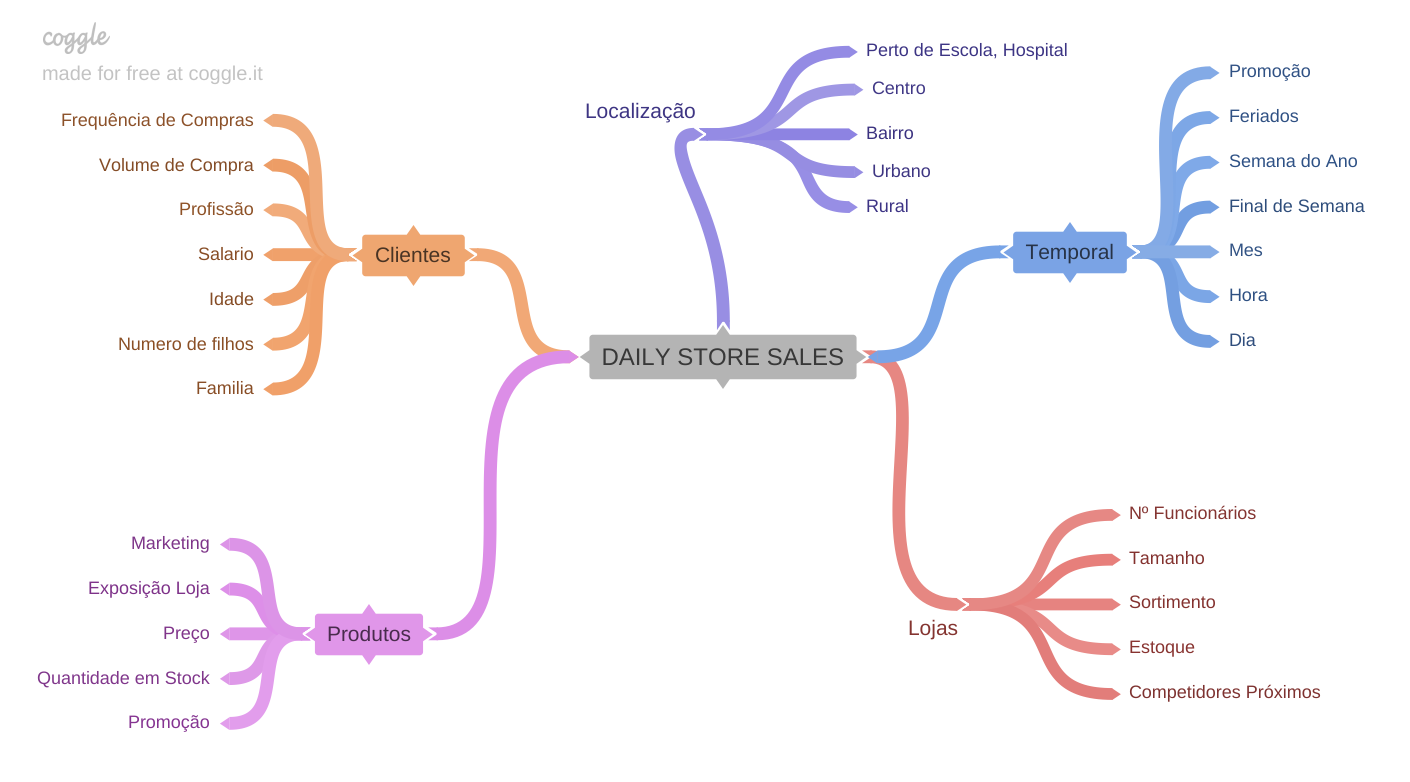

In [26]:
PATH = 'D:\\Backup\\Comunidade DS\\Cursos\\DS_Producao\\images\\MindMapHypothesis.png'
Image(PATH)

## 2.2 Criação de Hipóteses

### 2.1.1 Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais;

**2.** Lojas com maior capacidade de estoque deveriam vender mais;

**3.** Lojas com maior porte deveriam vender mais;

**4.** Lojas com maior sortimento deveriam vender mais;

**5.** Lojas com competidores mais próximos deveriam vender menos;

**6.** Lojas com competidores à mais tempo deveriam vender mais;

### 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais;

**2.** Lojas com maior exposição de produtos nas vitrines deveriam vender mais;

**3.** Lojas que tem preços menores nos produtos deveriam vender mais;

**4.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais;

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais;

**6.** Lojas com mais dias de promoção deveriam vender mais;

**7.** Lojas com mais promoções consecutivas deveriam vender mais;

### 2.1.3 Hipóteses Temporais

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais;

**2.** Lojas deveriam vender mais ao longo dos anos;

**3.** Lojas deveriam vender mais no segundo semestre do ano;

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês;

**5.** Lojas deveriam vender mais aos finais de semana;

**6.** Lojas deveriam vender mais durante os feriados escolares;

## 2.3 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais;

**2.** Lojas com competidores mais próximos deveriam vender menos;

**3.** Lojas com competidores à mais tempo deveriam vender mais;

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais;

**5.** Lojas com mais dias de promoção deveriam vender mais;

**6.** Lojas com mais promoções consecutivas deveriam vender mais;

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais;

**8.** Lojas deveriam vender mais ao longo dos anos;

**9.** Lojas deveriam vender mais no segundo semestre do ano;

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês;

**11.** Lojas deveriam vender mais aos finais de semana;

**12.** Lojas deveriam vender mais durante os feriados escolares;

## 2.4 Feature Engineering

In [27]:
import datetime

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [28]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Passo 03 - Filtragem de Variáveis

In [29]:
df3 = df2.copy()
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [30]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [31]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 Passo 04 - Analise Exploratoria dos Dados

In [32]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response Variable

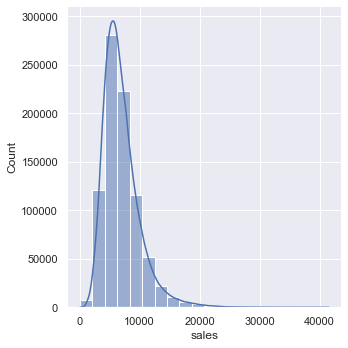

In [33]:
sns.displot(df4['sales'], bins=20, kde=True)

### 4.1.2 Numerical Variables

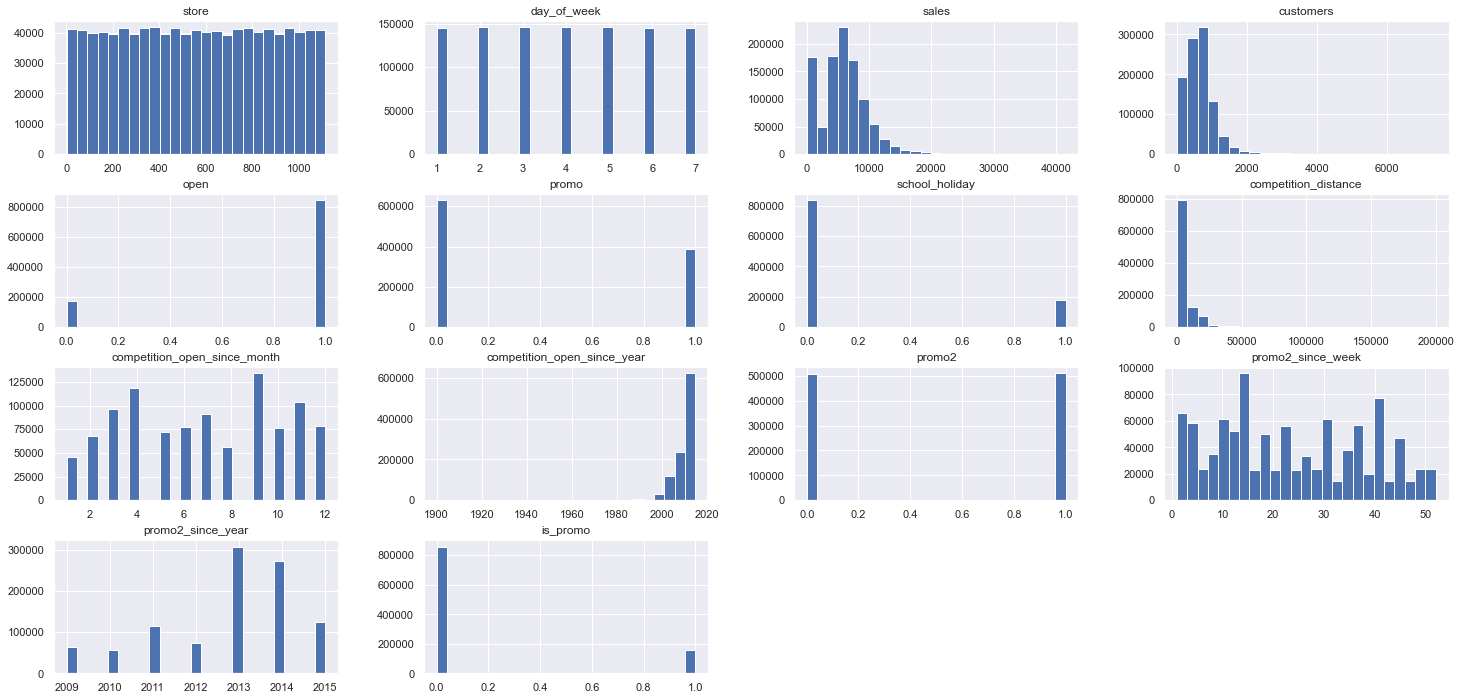

In [34]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical Variables

In [35]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [36]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

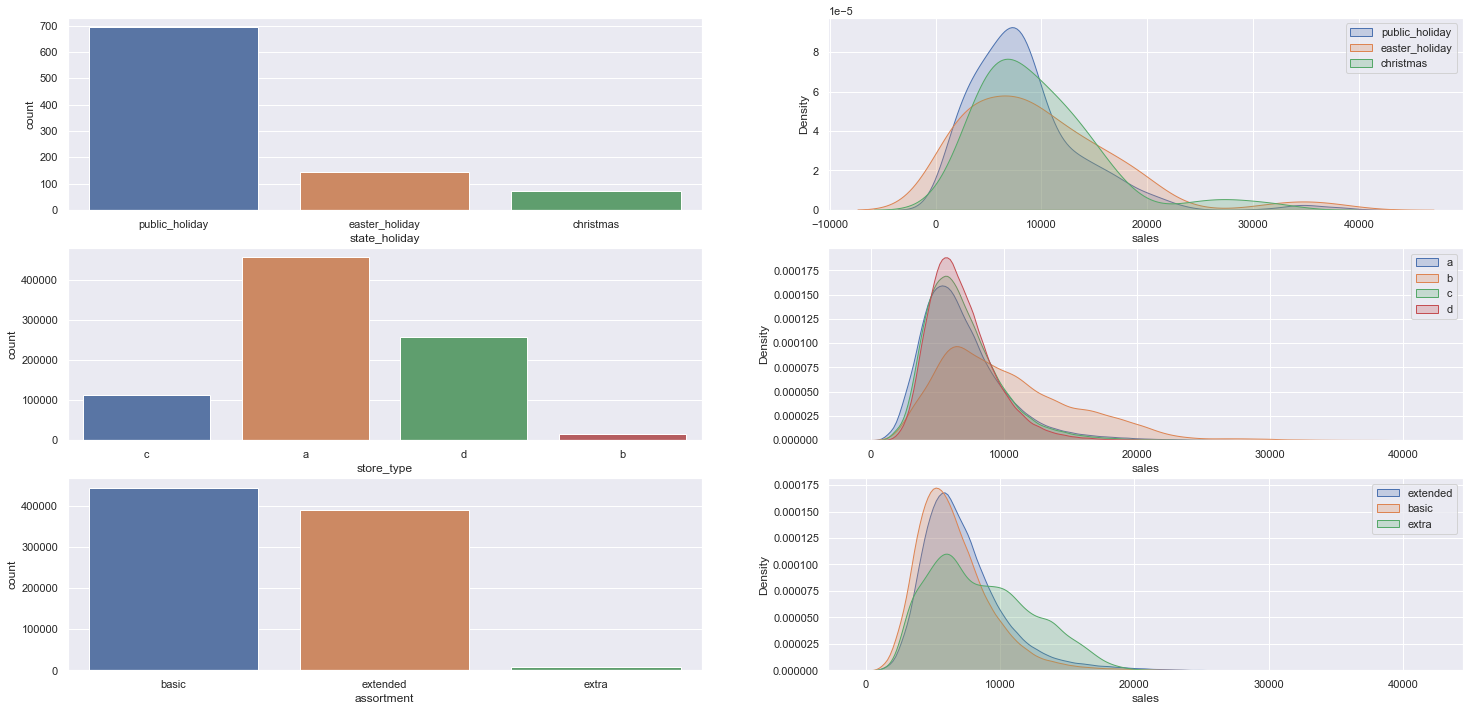

In [37]:
#state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True, palette="bright")
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True, palette="bright")
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True, palette="bright")
plt.legend()

#store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True, palette="bright")
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True, palette="bright")
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True, palette="bright")
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True, palette="bright")
plt.legend()

#assotment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True, palette="bright")
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True, palette="bright")
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True, palette="bright")
plt.legend()

## 4.2 Analise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais;

**FALSA.** Lojas com <font color='orange'>MAIOR SORTIMENTO</font> vendem <font color='orange'>MENOS</font>

In [38]:
# aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
# sns.barplot(x='assortment', y='sales', data=aux1);

# aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
# aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

# aux3 = aux2[aux2['assortment'] == 'extra']
# aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos;
**FALSA** Lojas com <font color='orange'>COMPETIDORES MAIS PRÓXIMOS</font> vendem <font color='orange'>MAIS</font>

In [39]:
# aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

# plt.subplot(1, 3, 1)
# sns.scatterplot(x='competition_distance', y='sales', data=aux1)

# plt.subplot(1, 3, 2)
# bins= list(np.arange(0, 20000, 1000))
# aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
# aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
# sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
# plt.xticks(rotation=90)

# plt.subplot(1, 3, 3)
# sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Lojas com competidores à mais tempo deveriam vender mais;

**FALSA** Lojas com <font color='orange'>COMPETIDORES À MAIS TEMPO</font> vendem a <font color='orange'>MENOS</font>

In [40]:
# plt.subplot(2, 1, 1)
# aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
# aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
# sns.barplot(x='competition_time_month', y='sales', data=aux2)
# plt.xticks(rotation=90);

# plt.subplot(2, 2, 3)
# sns.regplot(x='competition_time_month', y='sales', data=aux2)

# plt.subplot(2, 2, 4)
# sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais

**FALSA** Lojas com <font color='orange'>PROMOÇÕES ATIVAS POR MAIS TEMPO</font> <font color='red'>VENDEM MENOS</font>, depois de um certo período de promoção.

In [41]:
# aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# grid = GridSpec(2, 3)

# #promo extendida
# plt.subplot(grid[0,0])
# aux2 = aux1[aux1['promo_time_week'] > 0] 
# sns.barplot(x='promo_time_week', y='sales', data=aux2);
# plt.xticks(rotation=90);

# plt.subplot(grid[0, 1])
# sns.regplot(x='promo_time_week', y='sales', data=aux2);

# #promo regular
# plt.subplot(grid[1, 0])
# aux3 = aux1[aux1['promo_time_week'] < 0] 
# sns.barplot(x='promo_time_week', y='sales', data=aux3);
# plt.xticks(rotation=90);

# plt.subplot(grid[1, 1])
# sns.regplot(x='promo_time_week', y='sales', data=aux3);

# plt.subplot(grid[:, 2])
# sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>H5. Lojas com mais dias de promoção deveriam vender mais</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais

**FALSA** Lojas com <font color='orange'>MAIS PROMOÇÕES CONSECUTIVAS</font> <font color='red'>VENDEM MENOS</font>

In [42]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().sort_values('sales', ascending=True).reset_index()

,promo,promo2,sales
0,0,1,1289362241
1,1,1,1472275754
2,0,0,1482612096
3,1,0,1628930532


In [43]:
# aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
# ax = aux1.plot()

# aux2 = aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
# aux2.plot(ax=ax)

# ax.legend(labels=['Tradicional & Extendida', 'Tradicional']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais;

**FALSA** Lojas abertas durante o <font color='orange'>FERIADO DE NATAL VENDEM MENOS</font>

In [44]:
# aux = df4[df4['state_holiday'] != 'regular_day']

# plt.subplot(1, 2, 1)
# aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
# sns.barplot(x='state_holiday', y='sales', data=aux1);

# plt.subplot(1, 2, 2)
# aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
# sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)

### H8. Lojas deveriam vender mais ao longo dos anos;

**FALSA** Lojas <font color='orange'>VENDEM MENOS</font> ao longo dos anos

In [45]:
# aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

# plt.subplot(1, 3, 1)
# sns.barplot(x='year', y='sales', data=aux1);

# plt.subplot(1, 3, 2)
# sns.regplot(x='year', y='sales', data=aux1);

# plt.subplot(1, 3, 3)
# sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9. Lojas deveriam vender mais no segundo semestre do ano;

**FALSA** Lojas <font color='orange'>VENDEM MENOS</font> no <font color='orange'>SEGUNDO SEMESTRE</font> do ano

In [46]:
# aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

# plt.subplot(1, 3, 1)
# sns.barplot(x='month', y='sales', data=aux1);

# plt.subplot(1, 3, 2)
# sns.regplot(x='month', y='sales', data=aux1);

# plt.subplot(1, 3, 3)
# sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês;

- **VERDADEIRA** Lojas <font color='orange'>VENDEM MAIS</font> depois do dia 10 de cadas mês.
- **FALSA** Lojas <font color='orange'>VENDEM MENOS</font> depois do dia 10, quando olhamos a <font color='orange'>MÉDIA DE VENDAS DIARIA</font>. 

In [47]:
# aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

# plt.subplot(3, 1, 1)
# sns.barplot(x='day', y='sales', data=aux1);

# plt.subplot(3, 2, 3)
# sns.regplot(x='day', y='sales', data=aux1);

# plt.subplot(3, 2, 4)
# sns.heatmap(aux1.corr(method='pearson'), annot=True);

# # Sum sales of days

# aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x < 10 else 'after_10_days')
# aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

# plt.subplot(3, 2, 5)
# sns.barplot(x='before_after', y='sales', data=aux2);

# # Average per Day

# aux3 = aux1[['before_after', 'sales']].groupby('before_after').mean().reset_index()

# plt.subplot(3, 2, 6)
# sns.barplot(x='before_after', y='sales', data=aux3);
# plt.title('Average Sales per Day')

### H11. Lojas deveriam vender mais aos finais de semana;

**FALSA** Lojas <font color='orange'>VENDEM MENOS</font> nos <font color='orange'>FINAIS DE SEMANA</font>

In [48]:
# aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

# plt.subplot(1, 3, 1)
# sns.barplot(x='day_of_week', y='sales', data=aux1);

# plt.subplot(1, 3, 2)
# sns.regplot(x='day_of_week', y='sales', data=aux1);

# plt.subplot(1, 3, 3)
# sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H12. Lojas deveriam vender mais durante os feriados escolares;

**FALSA** Lojas <font color='orange'>VENDEM MENOS</font> durante os <font color='orange'>FERIADOS ESCOLARES</font>, porém nos meses de <font color='red'>Julho e Agosto</font> que as <font color='red'>VENDAS AUMENTAM</font>.

In [49]:
# aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
# plt.subplot(2, 1, 1)
# sns.barplot(x='school_holiday', y='sales', data=aux1);

# aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
# plt.subplot(2, 1, 2)
# sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)

### 4.2.1 Resumo das Hipoteses

In [50]:
from tabulate import tabulate 

In [51]:
tab = [['Hipoteses', 'Conclusão', 'Relevância'], 
       ['H1', 'Falsa', 'Baixa'], 
       ['H2', 'Falsa', 'Média'], 
       ['H3', 'Falsa', 'Média'], 
       ['H4', 'Falsa', 'Baixa'], 
       ['H5', '-', '-'], 
       ['H6', 'Falsa', 'Baixa'], 
       ['H7', 'Falsa', 'Média'], 
       ['H8', 'Falsa', 'Alta'], 
       ['H9', 'Falsa', 'Alta'], 
       ['H10', 'Verdadeira', 'Alta'], 
       ['H11', 'Falsa', 'Alta'], 
       ['H12', 'Falsa', 'Baixa']]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Falsa        Alta
H12          Falsa        Baixa


## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

<AxesSubplot:>

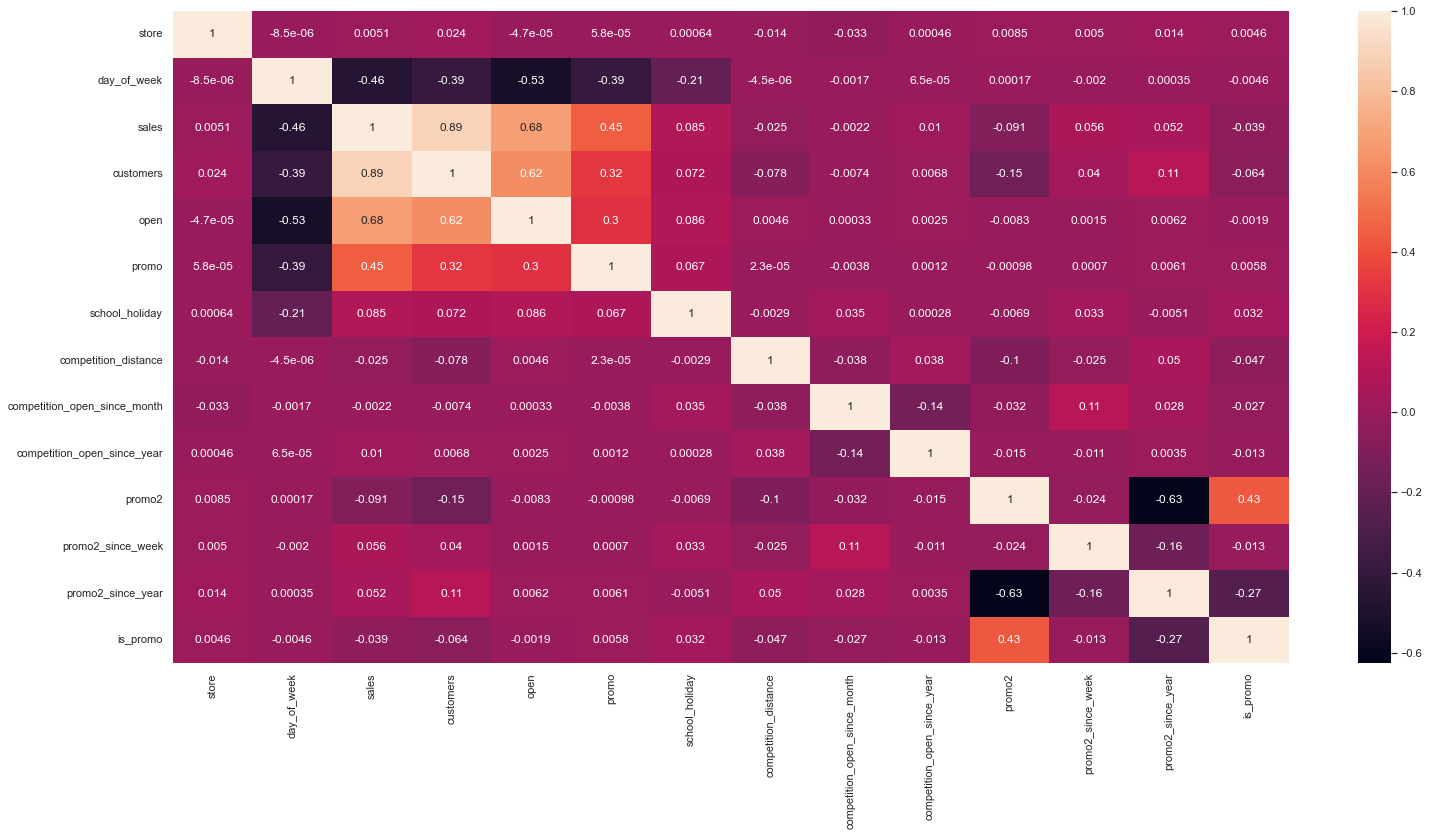

In [52]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

In [53]:
# Only Categorical Data
a = df4.select_dtypes(include='object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


<AxesSubplot:>

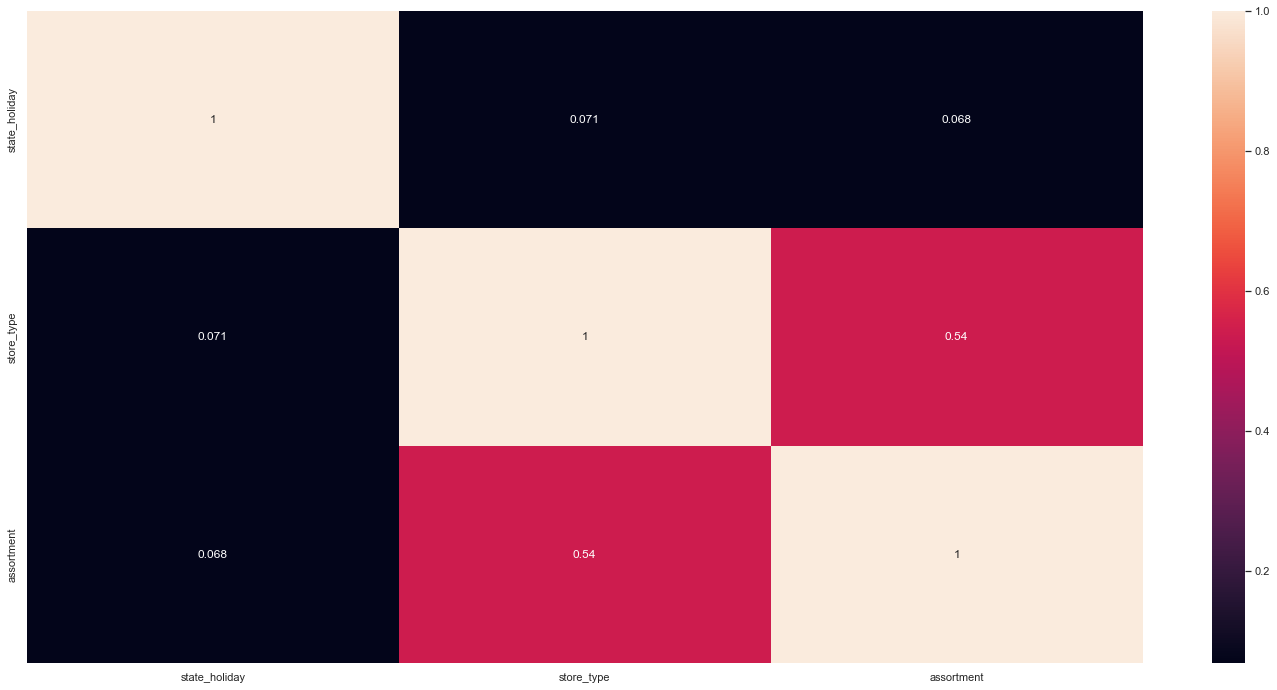

In [54]:
# Calculate Cramer V 
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final Dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3], 
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

# 5.0 Passo 05 - Data Preparation

In [55]:
df5 = df4.copy()

In [56]:
# Corrigindo o tipo de dados
df5['competition_time_month'] = df5['competition_time_month'].astype( 'int64' )
df5['promo_time_week'] = df5['promo_time_week'].astype( 'int64' )

## 5.1 Normalização

#### Olhando para o plot das variáveis númericas, podemos observar que nenhuma variável é próxima a uma <font color='orange'>Normal</font>. Sendo assim, não temos porque fazer a etapa de <font color='orange'>Normalização</font>.

## 5.2 Rescaling

<h4>Para saber qual método utilizar, foi plotado gráficos de <font color='orange'>Boxplot</font> das variáveis, com a finalidade de estudar os <font color='orange'>outliers</font> de cada uma</h4>

In [57]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month 
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

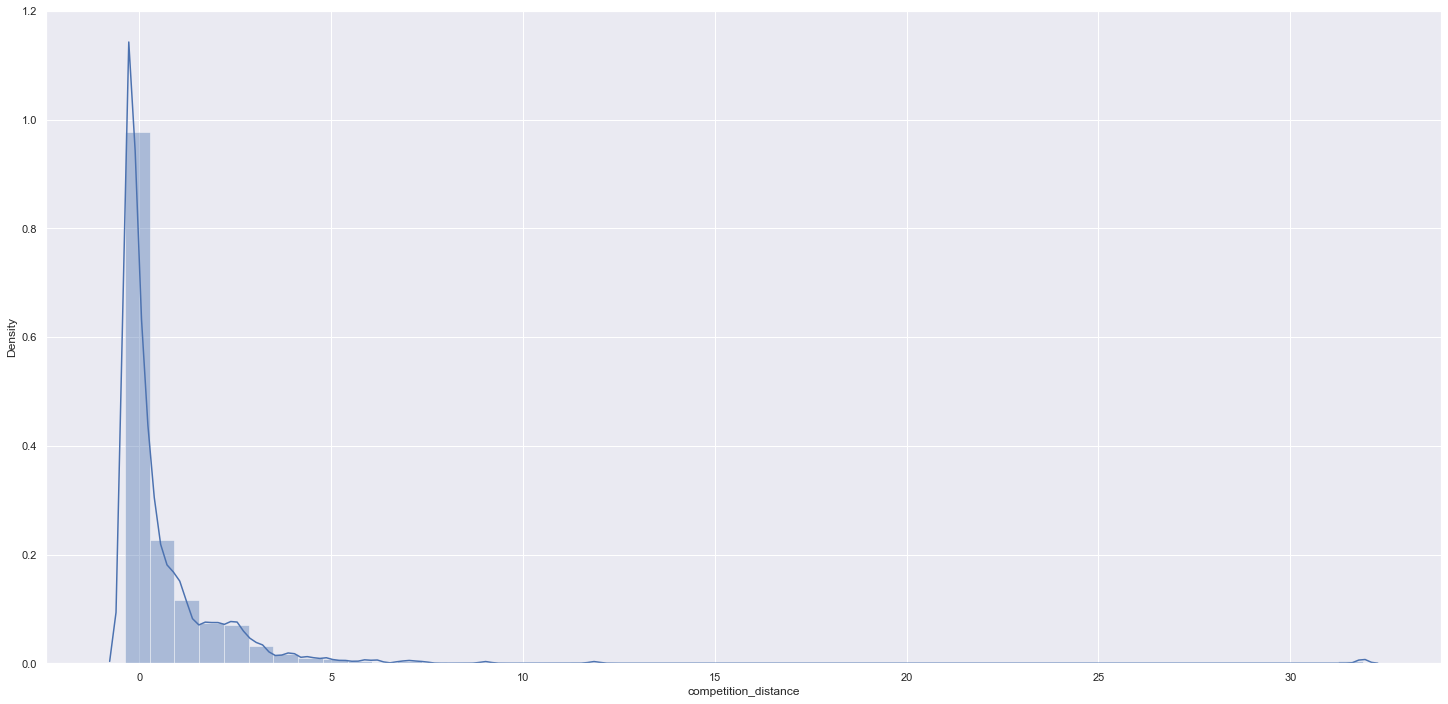

In [58]:
sns.distplot(df5['competition_distance']);

## 5.3 Transformação

### 5.3.1 Encoding

In [59]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [60]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.2 Nature Transformation

In [61]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))


# 6.0 Passo 06 - Feature Selection

In [62]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [63]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

### Separando 6 semanas para os dados de teste

In [64]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [65]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print('Training Min Date {}'.format(X_train['date'].min()))
print('Training Max Date {}'.format(X_train['date'].max()))

print('\nTest Min Date {}'.format(X_test['date'].min()))
print('Test Max Date {}'.format(X_test['date'].max()))

Training Min Date 2013-01-01 00:00:00
Training Max Date 2015-06-18 00:00:00

Test Min Date 2015-06-19 00:00:00
Test Max Date 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [66]:
# # training and test dataset for Boruta
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# Y_train_n = Y_train.values.ravel()

# # Define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # Define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

- Quantidade de Iterações;
- Variáveis Relevantes;
- Duvidas sobre as variáveis; 
- Variáveis rejeitadas;

### 6.2.1 Best Features from Boruta

In [67]:
# cols_selected = boruta.support_.tolist()

# # Best Features
# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # Not Selected Boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [68]:
# print('Colunas relevantes: {}'.format(cols_selected_boruta))
# print('\nColunas rejeitadas: {}'.format(cols_not_selected_boruta))

## 6.3 Manual Feature Selection

In [69]:
cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos']

# Columns to add 
feat_to_add = ['date', 'sales']

# Final Features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Passo 07 - Machine Learning Modeling

In [70]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [71]:
# aux1 = x_test.copy()
# aux1['sales'] = Y_test.copy()

# # Prediction
# aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
# aux1 = pd.merge(aux1, aux2, how='left', on='store')
# yhat_baseline = aux1['predictions']

# # Performance
# baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))

## 7.2. Linear Regression Model

In [72]:
# # Model
# lr = LinearRegression().fit(x_train, Y_train)

# # Prediction
# yhat_lr = lr.predict(x_test)

# # Performance
# lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
# lr_result

### 7.2.1 Linear Regression Model - Cross Validation

In [73]:
# lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
# lr_result_cv

## 7.3. Linear Regression Regularized Model - Laço

In [74]:
# # Model
# lrr = Lasso(alpha = 0.001).fit(x_train, Y_train)

# # Prediction
# yhat_lrr = lrr.predict(x_test)

# # Performance
# lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
# lrr_result

### 7.3.1 Lasso - Cross_Validation

In [75]:
# lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
# lrr_result_cv

## 7.4. Random Forest Regressor

In [76]:
# # Model
# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, Y_train)

# # Prediction
# yhat_rf = rf.predict(x_test)

# # Performance
# rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))

### 7.4.1 - Random Forest Regressor - Cross Validation

In [77]:
# rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
# rf_result_cv

## 7.5. XGBoost Regressor

In [78]:
# # Model
# model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
#                              n_estimators=100, 
#                              eta=0.01,
#                              max_depth=10, 
#                              colsample_bytree=0.9).fit(x_train, Y_train)

# # Prediction
# yhat_xgb = model_xgb.predict(x_test)

# # Performance
# xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
# xgb_result

In [79]:
# xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
# xgb_result_cv

## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [80]:
# modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
# modelling_result.sort_values('RMSE')

### 7.6.2 Real Performance - Cross Validation

In [81]:
# modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
# modelling_result_cv.sort_values('RMSE CV')

# 8.0 Passo 08 - Hyperparameter Fine Tuning

## 8.1 Random Search

In [82]:
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500], 
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9], 
    'min_child_weight': [3, 8, 15]
        }
MAX_EVAL = 10

In [83]:
# final_result = pd.DataFrame()
# df_param = pd.DataFrame()

# for i in range(MAX_EVAL): 
#     # choose values for parameters randomly
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     # print(hp)
    
#     df_param = df_param.append(hp, ignore_index=True)
    
#     # Model
#     model_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
#                                 n_estimators=hp['n_estimators'], 
#                                 eta=hp['eta'],
#                                 max_depth=hp['max_depth'], 
#                                 colsample_bytree=hp['colsample_bytree'], 
#                                 min_child_weight=hp['min_child_weight'])

#     # Performance
#     result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#     final_result = pd.concat([final_result, result])
    
# df_param

data = {'n_estimators': [2500.0, 2500.0, 1500.0, 3500.0, 1700.0, 1700.0, 3500.0, 2500.0, 3500.0, 1700.0], 
        'eta': [0.03, 0.01, 0.01, 0.03, 0.01, 0.03, 0.03, 0.03, 0.01, 0.03], 
        'max_depth': [3.0, 5.0, 3.0, 5.0, 9.0, 9.0, 5.0, 9.0, 9.0, 3.0], 
        'subsample': [0.5, 0.7, 0.5, 0.5, 0.1, 0.5, 0.7, 0.7, 0.1, 0.5], 
        'colsample_bytree': [0.3, 0.3, 0.3, 0.9, 0.3, 0.3, 0.3, 0.7, 0.3, 0.7], 
        'min_child_weight': [15.0, 3.0, 15.0, 3.0, 15.0, 3.0, 8.0, 8.0, 15.0, 8.0]}

df_param = pd.DataFrame(data)
df_param

,n_estimators,eta,max_depth,subsample,colsample_bytree,min_child_weight
0,2500.0,0.03,3.0,0.5,0.3,15.0
1,2500.0,0.01,5.0,0.7,0.3,3.0
2,1500.0,0.01,3.0,0.5,0.3,15.0
3,3500.0,0.03,5.0,0.5,0.9,3.0
4,1700.0,0.01,9.0,0.1,0.3,15.0
5,1700.0,0.03,9.0,0.5,0.3,3.0
6,3500.0,0.03,5.0,0.7,0.3,8.0
7,2500.0,0.03,9.0,0.7,0.7,8.0
8,3500.0,0.01,9.0,0.1,0.3,15.0
9,1700.0,0.03,3.0,0.5,0.7,8.0


In [84]:
data = {'Model Name': ['XGBoost Regressor'] * 10, 
        'MAE CV': ['1122.68+/-121.52', '1100.76+/-114.79', '1502.48+/-170.35', '540.88+/-66.41', '698.81+/-74.36', '497.01+/-87.37', '628.1+/-74.26', '460.94+/-123.82', '526.68+/-70.58', '1152.64+/-120.34'], 
        'MAPE CV': ['0.17+/-0.01', '0.16+/-0.01', '0.22+/-0.01', '0.08+/-0.01', '0.1+/-0.01', '0.07+/-0.01', '0.09+/-0.01', '0.07+/-0.02', '0.08+/-0.01', '0.17+/-0.01'], 
        'RMSE CV': ['1578.18+/-129.4', '1555.4+/-131.0', '2093.83+/-209.12', '710.11+/-72.35', '949.66+/-79.67', '649.55+/-98.95', '827.13+/-65.95', '596.25+/-150.48', '692.85+/-74.86', '1625.48+/-133.31']}

final_result = pd.DataFrame(data)
final_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1122.68+/-121.52,0.17+/-0.01,1578.18+/-129.4
1,XGBoost Regressor,1100.76+/-114.79,0.16+/-0.01,1555.4+/-131.0
2,XGBoost Regressor,1502.48+/-170.35,0.22+/-0.01,2093.83+/-209.12
3,XGBoost Regressor,540.88+/-66.41,0.08+/-0.01,710.11+/-72.35
4,XGBoost Regressor,698.81+/-74.36,0.1+/-0.01,949.66+/-79.67
5,XGBoost Regressor,497.01+/-87.37,0.07+/-0.01,649.55+/-98.95
6,XGBoost Regressor,628.1+/-74.26,0.09+/-0.01,827.13+/-65.95
7,XGBoost Regressor,460.94+/-123.82,0.07+/-0.02,596.25+/-150.48
8,XGBoost Regressor,526.68+/-70.58,0.08+/-0.01,692.85+/-74.86
9,XGBoost Regressor,1152.64+/-120.34,0.17+/-0.01,1625.48+/-133.31


## 8.2 Final Model

In [85]:
param_tuned = {
    'n_estimators': 2500, 
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.7,
    'colsample_bytree': 0.7, 
    'min_child_weight': 8
        }

In [86]:
# Model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror', 
                                   n_estimators=param_tuned['n_estimators'], 
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'], 
                                   colsample_bytree=param_tuned['colsample_bytree'], 
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, Y_train)

# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# # Performance
# result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
# result

# final_result = pd.concat([final_result, result])
# final_result

data = {'Model Name': ['XGBoost Regressor'],
        'MAE': [620.001784], 
        'MAPE': [0.090126], 
        'RMSE': [910.062408]}

result = pd.DataFrame(data)
result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,620.001784,0.090126,910.062408


# 9.0 Passo 09 - Tradução e Interpretação do Erro

In [87]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [88]:
# Sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

df92.head()

,store,predictions,MAE,MAPE
0,1,159148.015625,277.761164,0.062629
1,2,174757.390625,332.268179,0.068801
2,3,262192.468750,521.656659,0.074574
3,4,337052.375000,929.171308,0.089235
4,5,172044.281250,387.181486,0.088477


In [89]:
# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Order Columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
616,617,234513.765625,233989.816551,235037.714699,523.949074,0.082737
986,987,240168.609375,239552.758604,240784.460146,615.850771,0.093791
187,188,189329.046875,188680.175788,189977.917962,648.871087,0.106968
1066,1067,221394.156250,221007.844977,221780.467523,386.311273,0.060106
902,903,389053.656250,387469.287558,390638.024942,1584.368692,0.126408


In [90]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104542.257812,101227.726601,107856.789024,3314.531211,0.550214
908,909,237480.171875,229937.152323,245023.191427,7543.019552,0.508211
875,876,201161.859375,197137.607613,205186.111137,4024.251762,0.307657
594,595,378848.500000,374784.594964,382912.405036,4063.905036,0.278157
721,722,350436.312500,348513.601035,352359.023965,1922.711465,0.259134


<AxesSubplot:xlabel='store', ylabel='MAPE'>

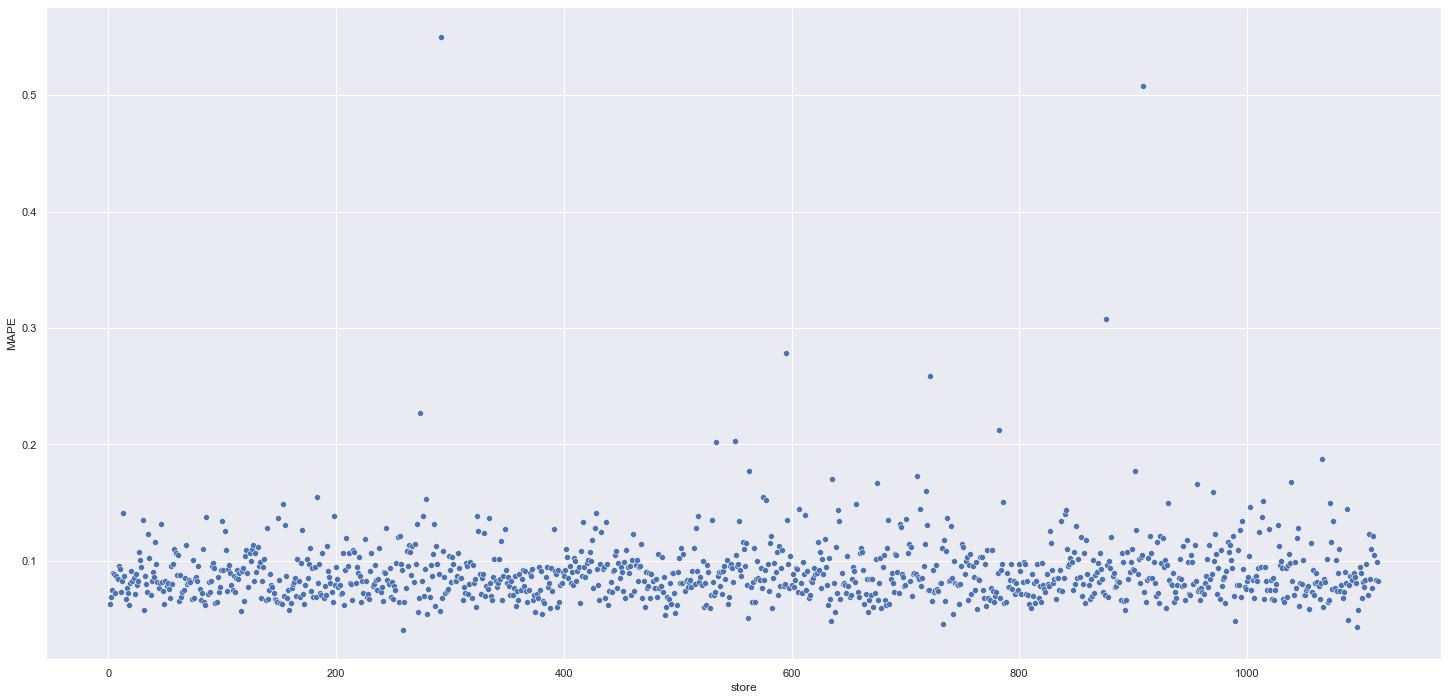

In [91]:
sns.scatterplot(data= df92, x='store', y='MAPE')

## 9.2 Total Performance

In [92]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: sum(x), axis=0).reset_index().rename(columns= {'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93.head()

,Scenario,Values
0,predictions,"R$284,045,120.00"
1,worst_scenario,"R$283,349,670.85"
2,best_scenario,"R$284,740,504.73"


## 9.3 Machine Learning Performance

In [93]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

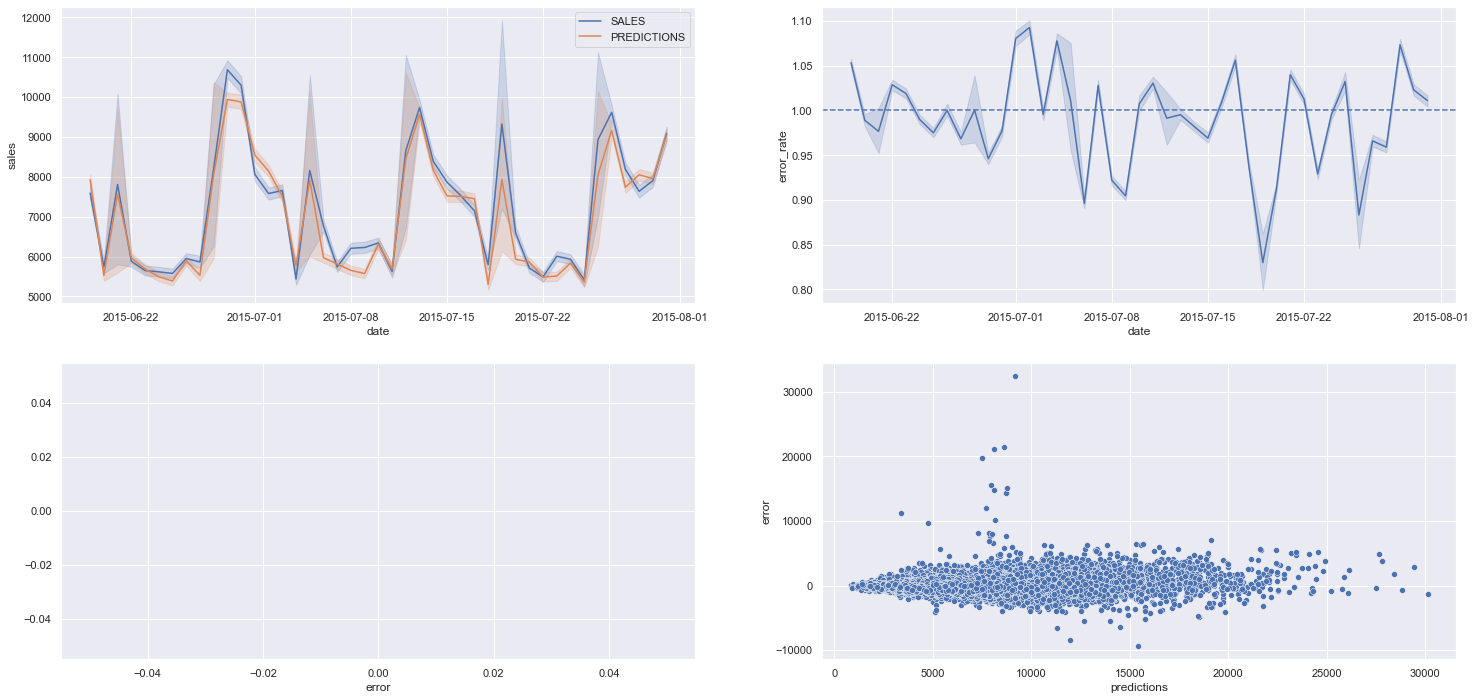

In [94]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle= '--')

plt.subplot(2, 2, 3)
sns.lineplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'])

# 10.0 Passo 10 - Deploy Model to Production 

In [95]:
pickle.dump(model_xgb_tuned, open('D:/Backup/Comunidade DS/Cursos/DS_Producao/model/model_rossmann.pkl', 'wb'))

## 10.1 Rossman Class

In [26]:
import pickle
import inflection
import pandas as pd 
import numpy as np 
import math
import datetime
import json

class Rossman(object):
    def __init__(self):
        self.home_path='D:/Backup/Comunidade DS/Cursos/DS_Producao/Aulas/Modulo 10 - Deploy do modelo em Produção/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        
    
    def data_cleaning(self, df1):
        
    # 1.0 Descrição dos Dados

        ## 1.1 Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new
                
        ## 1.3 Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5 Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6 Change Types

        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )
            
        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )        

        return df1
    
    def feature_engineering(self, df2): 
        
    # 2.0 Passo 02 - Feature Engineering
        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


    # 3.0 Passo 03 - Filtragem de Variáveis

        ## 3.1 Filtragem das Linhas
        df2 = df2[(df2['open'] != 0)]

        ## 3.2 Seleção das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
            
        return df2
    
    def data_preparation(self, df5):
    ## 5.2 Rescaling
        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']].values)
        
        # competition time month 
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']].values)
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = self.year_scaler.transform(df5[['year']].values)     
        
    ## 5.3 Transformação
    ### 5.3.1 Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])
        
        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
        
        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
        
        ### 5.3.2 Nature Transformation
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 
                                'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 
                                'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 
                                'week_of_year_sin', 'week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data): 
        
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expml(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [28]:
import pickle
import pandas as pd
from flask              import Flask, request, Response
from rossmann.Rossmann  import Rossmann

# Loading Model
model = pickle.load(open('D:/Backup/Comunidade DS/Cursos/DS_Producao/model/model_rossmann.pkl', 'rb'))

# Inialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: # There is data
        
        if isinstance(test_json, dict): # Unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # Multiple example       
            test_raw = pd.DataFrame(test_json, columns= test_json[0].keys())
            
        # Instantiate Rossmann Class    
        pipeline = Rossman()    
            
        # Data Cleaning    
        df1 = pipeline.data_cleaning(test_raw)
        
        # Feature Engineering
        df2 = pipeline.feature_engineering(df1)
        
        # Data Preparation
        df3 = pipeline.data_preparation(df2)
        
        # Prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
         
        return df_response    
            
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__': 
    app.run('192.168.15.4')

## 10.3 API Tester

In [46]:
import requests

In [47]:
# loading test dataset
df10 = pd.read_csv('D:/Backup/Comunidade DS/Cursos/DS_Producao/data/test.csv')

In [48]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# Choose store for prediction
df_test = df_test[df_test['Store'].isin([22])]

# remove closed days
df_test = df_test[df_test['Open'] == 1]
df_test = df_test[~df_test['Open'].isnull()]
df_test.drop('Id', axis=1, inplace=True)

In [49]:
# convert Dataframe to Json
data = json.dumps(df_test.to_dict(orient='records'))

In [50]:
# API Call
url = 'http://192.168.15.4:5000/rossman/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 404


In [52]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [ ]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))